<a href="https://colab.research.google.com/github/sanosenx86/CSE5522SP20/blob/lab4/5522_lab4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

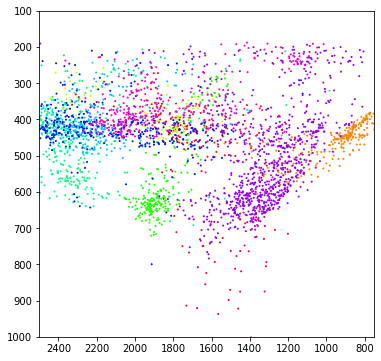

In [0]:
# first, read in the data and build a scatterplot showing the vowel formants
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
url='https://raw.githubusercontent.com/efosler/cse5522data/master/vowelfmts.csv'
df=pd.read_csv(url)

# This function will plot the vowels as a scatterplot with different colors
# using the traditional F2 vs F1 inverted plot.  This puts high (close) vowels
# at the top of the plot and low vowels (open) at the bottom.  Front vowels
# are to the left; back vowels to the right.  Optionally can plot a boundary.

def plotvowels(df,weights=None):
  # this next bit converts the label into a colormap value between 0 and 1
  vowels=df['vowel'].unique()
  vmap={}
  for i in range(vowels.shape[0]):
    vmap[vowels[i]]=float(i)/float(vowels.shape[0]-1)
  df['color']=df['vowel'].map(vmap)
  # plot the scatterplot
  plt.figure(num=1,figsize=(6,6))
  plt.scatter(df['f2'],df['f1'],s=1,c=df['color'],cmap='gist_rainbow')
  plt.gca().set_ylim([100,1000])
  plt.gca().set_xlim([750,2500])
  plt.gca().invert_xaxis()
  plt.gca().invert_yaxis()
  if weights is not None:
    dmin=df['f2'].min()
    dmax=df['f2'].max()
    plt.plot(np.array([dmin,dmax]),
             np.array([-(dmin*weights[0]+weights[2])/(weights[1]),
                       -(dmax*weights[0]+weights[2])/(weights[1])]),
             'b--'
             )

# Plot the vowel data.  Compare against the IPA chart online.      
plotvowels(df)

In [0]:
#Curious.
df.head()

,f1,f2,close,near-close+,close-mid+,mid+,open-mid+,back,central-or-back,rounded,vowel,color
0,1001.469604,1393.008423,0,0,0,0,0,1,1,1,ah,0.0
1,295.790009,2161.581055,0,0,0,0,0,1,1,1,ah,0.0
2,312.630615,1891.233398,0,0,0,0,0,1,1,1,ah,0.0
3,317.177032,1916.116577,0,0,0,0,0,1,1,1,ah,0.0
4,331.080505,2309.110596,0,0,0,0,0,1,1,1,ah,0.0


In [0]:
#Split train/test dataset.
from sklearn.model_selection import train_test_split
train_data, test_data, train_targets, test_targets = train_test_split(df[['f1','f2']],df[['close','near-close+','close-mid+','mid+','open-mid+','back','central-or-back','rounded','vowel']])

In [0]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
torch.manual_seed(2)

Preprocessing data here to make all three models train and evaluate on same datasets.

In [0]:
#MinMax normalize.
from sklearn.preprocessing import MinMaxScaler

# Take this scaler as a part of model. It fits in train data, and use the same
# parameter to process the test data.
mmscaler=MinMaxScaler()
mmscaler.fit(train_data.values)
ntrain_data=mmscaler.transform(train_data.values)
ntest_data=mmscaler.transform(test_data.values)

xtrain=torch.FloatTensor(ntrain_data)
xtest=torch.FloatTensor(ntest_data)

#prepare target.
ytrain=torch.LongTensor(train_targets['vowel'].astype('category').cat.codes.values)
ytest=torch.LongTensor(test_targets['vowel'].astype('category').cat.codes.values)

In [0]:
#Train function
def trainNN(model, epoches, train_data, train_target, learning_rate):
  optimizer=optim.Adam(model.parameters(), lr=learning_rate)
  loss_func=nn.CrossEntropyLoss()
  for n in range(epoches):
    total_loss=0.0
    for i in range(len(train_target)):
      #Prepare and encode data.
      x=train_data[i]
      y=train_target[i].unsqueeze(0)

      model.zero_grad()
      pred=model.forward(x, train=True)
      loss=loss_func(pred, y)
      total_loss+=loss

      loss.backward()
      optimizer.step()
      
      if (i+1)%600 == 0:
        print('Epoch [{}/{}], Step [{}/{}], Average Loss: {:.4f}'
          .format(n + 1, epoches, i + 1, train_data.shape[0], total_loss / i))
    print(f"loss on epoch {n+1} = {total_loss}")
  
  return model

def evalNN(model, test_data, test_target):
  n_correct=0
  for i in range(len(test_target)):
    probs = model.forward(test_data[i], train=False)
    pred = torch.argmax(probs)
    if pred == test_target[i]:
        n_correct += 1
  print("Accuracy: %s" % (float(n_correct) / float(len(test_target))))

##Part 1: Using the vowel data from Part 2 of the HandsOn, construct a 2-layer MLP with 100 hidden units, predicting the vowel class.  Note that the traditional way to do this is to have a softmax output with a cross entropy loss.  Pytorch does this using the torch.nn.CrossEntropyLoss function, which expects as its input the linear layer (it builds the softmax function into the loss).  You will need to  convert labels to indices for output units.

In [0]:
class VowelModelL2(nn.Module):
    def __init__(self, input_dim, hid_dim, output_dim):
      (self.DINP, self.DHID, self.DOUT) = (input_dim, hid_dim, output_dim)
      # initialze the superclass
      super(VowelModelL2, self).__init__()
      # this will create a linear layer with input_dim x hid_dim parameters
      # in addition to a bias unit with hid_dim parameters
      self.l1 = nn.Linear(input_dim, hid_dim)
      self.sigmoid=nn.Sigmoid()
      # same thing here except hid_dim x output_dim
      self.l2 = nn.Linear(hid_dim, output_dim)

      nn.init.xavier_uniform_(self.l1.weight)
      nn.init.xavier_uniform_(self.l2.weight)
    
    # this is where the meat of the action is
    def forward(self, x, train=False):
        x = self.l1(x)  # linear combination of inputs
        x = self.sigmoid(x) # then through sigmoid - output of first layer
        x = self.l2(x).unsqueeze(0) # linear combination of hidden units
        return x

In [0]:
model=VowelModelL2(2,100,9)
model=trainNN(model, 7, xtrain, ytrain, 3e-2)

Epoch [1/7], Step [600/2427], Average Loss: 1.9938
Epoch [1/7], Step [1200/2427], Average Loss: 1.7802
Epoch [1/7], Step [1800/2427], Average Loss: 1.6502
Epoch [1/7], Step [2400/2427], Average Loss: 1.5763
loss on epoch 1 = 3815.46484375
Epoch [2/7], Step [600/2427], Average Loss: 1.3328
Epoch [2/7], Step [1200/2427], Average Loss: 1.3606
Epoch [2/7], Step [1800/2427], Average Loss: 1.3298
Epoch [2/7], Step [2400/2427], Average Loss: 1.3106
loss on epoch 2 = 3176.6103515625
Epoch [3/7], Step [600/2427], Average Loss: 1.2605
Epoch [3/7], Step [1200/2427], Average Loss: 1.2870
Epoch [3/7], Step [1800/2427], Average Loss: 1.2613
Epoch [3/7], Step [2400/2427], Average Loss: 1.2438
loss on epoch 3 = 3015.62548828125
Epoch [4/7], Step [600/2427], Average Loss: 1.2048
Epoch [4/7], Step [1200/2427], Average Loss: 1.2316
Epoch [4/7], Step [1800/2427], Average Loss: 1.2095
Epoch [4/7], Step [2400/2427], Average Loss: 1.1929
loss on epoch 4 = 2892.736083984375
Epoch [5/7], Step [600/2427], Avera

In [0]:
evalNN(model, xtest, ytest)

Accuracy: 0.5345679012345679


It's performance is not that good. It's accuracy on test set is 0.5666666666666667

##Part 2 (30 points):  Develop an experiment with 2 (new) different variations of the model (e.g., different widths, numbers of layers, activation functions, etc).   Create a short writeup explaining (1) why you chose the variations, and (2) how it affected performance on the test set.

**2.1** Use 4 layer with leakyReLU activation. Dimension is 100, 50, 25

In [0]:
class VowelModelL4(nn.Module):
    def __init__(self, input_dim, hid1_dim, hid2_dim, hid3_dim, output_dim):
      (self.DINP, self.DOUT) = (input_dim, output_dim)
      # initialze the superclass
      super(VowelModelL4, self).__init__()
      # this will create a linear layer with input_dim x hid_dim parameters
      # in addition to a bias unit with hid_dim parameters
      self.l1 = nn.Linear(input_dim, hid1_dim)
      self.leakyrelu=nn.LeakyReLU()
      # same thing here except hid_dim x output_dim
      self.l2 = nn.Linear(hid1_dim, hid2_dim)
      self.l3 = nn.Linear(hid2_dim, hid3_dim)
      self.l4 = nn.Linear(hid3_dim, output_dim)

      nn.init.xavier_uniform_(self.l1.weight)
      nn.init.xavier_uniform_(self.l2.weight)
      nn.init.xavier_uniform_(self.l3.weight)
      nn.init.xavier_uniform_(self.l4.weight)
    
    # this is where the meat of the action is
    def forward(self, x, train=False):
        x = self.l1(x)  # linear combination of inputs
        x = self.leakyrelu(x) # then through sigmoid - output of first layer
        x = self.l2(x) # linear combination of hidden units
        x = self.leakyrelu(x)
        x = self.l3(x)
        x = self.leakyrelu(x)
        x = self.l4(x).unsqueeze(0)
        return x

In [0]:
model=VowelModelL4(2,100,50,25,9)
model=trainNN(model, 10, xtrain, ytrain, 2e-3)

Epoch [1/10], Step [600/2427], Average Loss: 1.8239
Epoch [1/10], Step [1200/2427], Average Loss: 1.6644
Epoch [1/10], Step [1800/2427], Average Loss: 1.5528
Epoch [1/10], Step [2400/2427], Average Loss: 1.4890
loss on epoch 1 = 3604.655517578125
Epoch [2/10], Step [600/2427], Average Loss: 1.2941
Epoch [2/10], Step [1200/2427], Average Loss: 1.3134
Epoch [2/10], Step [1800/2427], Average Loss: 1.2759
Epoch [2/10], Step [2400/2427], Average Loss: 1.2439
loss on epoch 2 = 3016.97607421875
Epoch [3/10], Step [600/2427], Average Loss: 1.1499
Epoch [3/10], Step [1200/2427], Average Loss: 1.1819
Epoch [3/10], Step [1800/2427], Average Loss: 1.1617
Epoch [3/10], Step [2400/2427], Average Loss: 1.1419
loss on epoch 3 = 2772.200927734375
Epoch [4/10], Step [600/2427], Average Loss: 1.0858
Epoch [4/10], Step [1200/2427], Average Loss: 1.1157
Epoch [4/10], Step [1800/2427], Average Loss: 1.1010
Epoch [4/10], Step [2400/2427], Average Loss: 1.0847
loss on epoch 4 = 2635.664794921875
Epoch [5/10],

In [0]:
evalNN(model, xtest, ytest)

I choose 4 layers because more layers increases the ability of model to approximate. As the layer and node increases, the computation cost is higher so I use leakyReLU rather than sigmoid as hidden layer activation to boost its speed. Finally, its performance is slightly higher than the original one. It's accuracy on test set is 0.6037037037037037


**2.2** Go deeper. Use 8 layers with dropout and hidden dimension is 100.   
relu->tanh->relu->dropout->tanh->relu->tanh->dropout->relu->softmax

In [0]:
class VowelModelL8FixDim(nn.Module):
    def __init__(self, input_dim, hid_dim, output_dim):
      (self.DINP, self.DOUT) = (input_dim, output_dim)
      # initialze the superclass
      super(VowelModelL8FixDim, self).__init__()
      # this will create a linear layer with input_dim x hid_dim parameters
      # in addition to a bias unit with hid_dim parameters
      self.leakyrelu=nn.LeakyReLU()
      self.tanh=nn.Tanh()
      self.lin = nn.Linear(input_dim, hid_dim)
      # same thing here except hid_dim x output_dim
      self.l1 = nn.Linear(hid_dim, hid_dim)
      self.l2 = nn.Linear(hid_dim, hid_dim)
      self.l3 = nn.Linear(hid_dim, hid_dim)
      self.l4 = nn.Linear(hid_dim, hid_dim)
      self.l5 = nn.Linear(hid_dim, hid_dim)
      self.l6 = nn.Linear(hid_dim, hid_dim)
      self.lout = nn.Linear(hid_dim, output_dim)
      self.dropout=nn.Dropout(0.2)

      nn.init.xavier_uniform_(self.lin.weight)
      nn.init.xavier_uniform_(self.l1.weight)
      nn.init.xavier_uniform_(self.l2.weight)
      nn.init.xavier_uniform_(self.l3.weight)
      nn.init.xavier_uniform_(self.l4.weight)
      nn.init.xavier_uniform_(self.l5.weight)
      nn.init.xavier_uniform_(self.l6.weight)
      nn.init.xavier_uniform_(self.lout.weight)

    # this is where the meat of the action is
    def forward(self, x, train=False):
      self.train(train)
      x = self.lin(x)  # linear combination of inputs
      x = self.leakyrelu(x) # then through sigmoid - output of first layer
      x = self.l1(x)
      x = self.tanh(x)
      x = self.l2(x)
      x = self.leakyrelu(x)
      if(train): x = self.dropout(x)
      x = self.l3(x)
      x = self.tanh(x)
      x = self.l4(x)
      x = self.leakyrelu(x)
      x = self.l5(x)
      x = self.tanh(x)
      if(train): x = self.dropout(x)
      x = self.l6(x)
      x = self.leakyrelu(x)
      x = self.lout(x).unsqueeze(0)
      return x

In [0]:
model=VowelModelL8FixDim(2,100,9)
model=trainNN(model, 12, xtrain, ytrain, 7e-4)

In [0]:
evalNN(model, xtest, ytest)

I use 8 layers to see if add more layers will increase its performance (I guess no). To avoid overfitting, I add two dropout layer into the model. To avoid gradient explosion and gradient vanishing, I use leakyReLU->tanh as activation. Finally, it's performance is slightly increased. It's accuracy on test set is 0.6234567901234568